# How should I categorize these products?
## A comparison of clustering, classification and direct prompting to categorise retail products

## Executive Summary

> Using [online retail data available in UCI](https://archive.ics.uci.edu/dataset/502/online+retail+ii), I compare 4 methods to group +-4000 products into their categories: K-Means Clustering using TF/IDF; K-Means clustering using Embed LLM; Supervised learning using TFIDIF; Supervised Learning with embed LLM and Direct Prompting using LLM. The result shows that direct prompting is preferable for quick attempt in grouping product. However, for a bigger data and a more precise categorisation, classification and clustering with embed LLM to transform text, would yields a more precise grouping.

## Project Description

### Problem
In data analysis, grouping is one way to get the sense of our data without going into the detail of each items. Looking at sales performance? We break it down into group of regions. Analysing user preference? We put them into age-group. Trying to visualise profit data? We create bar chart showing profit per product category.

Some of us are lucky enough to get the category data in hands. However, there are times where we have to deal with raw data without any categories to use. Maybe we handle transactions from our local SME who previously did not have proper database. Or we help a traditional company who just transitioned into big data analytic. Or maybe we have a collection of old newspaper articles which we're going to digitalise. And in these cases, NLP - or specifically text classification - comes in handy. Text classification has been one of the earliest problem in NLP and through the times, various methods have been developed, including LLM, the latest breakthrough in NLP and Generative AI.

Here, using retail online transaction data available in UCI ML open data, I wanna create category label for each products in the transaction data. Labelling product solely based on their name for sure is a in the smaller scale of text classification, and as much as an LLM effective in generating text based on user's prompt, it may not perform better in classifying products into categories - compared to a more traditional apporach. Therefore, in this project, I tried to compare the result of product labelling using direct prompting with a more traditional methods in NLP through supervised and unsupervise learning.

### Project Goal
The goal of this project is to get a precise category labels of products, and find the most efficient method to do so - in terms of computing resource and human-time consumed in the process.

### Dataset
The dataset used in this project is downloaded from: [online retail data available in UCI](https://archive.ics.uci.edu/dataset/502/online+retail+ii) which then preprocessed to get 4276 distinct product names.

#### Method
1. Unsupervised Learning with TF/IDF
2. Unsupervised Learning with sentence transformer model: all-MiniLM-L6-v2
3. Supervised Learning with TF/IDF
4. Supervised Learning with sentence transformer model: all-MiniLM-L6-v2
5. Direct Prompting with LLM

### Result

#### Unsupervised TF/IDF vs LLM
Creating category group for product names using unsupervised learning is a preferably method especially when we don't have any labelled data and with no prior information of what are there in the product list. However, since the cluster normally comes with cluster number, we need additional step to interpret what is the category in each cluster.
As we compare the TF/IDF method to BERT library from huggingface (all-MiniLM-L6-v2), there is no significance difference in the number of evaluation metric such as the inertia. However, the LLM clusters clearly shows better cluster distribution. The cluster created using TF/IDF are mostly centralized into one cluster, meanwhile the cluster created using LLM is more evenly distributed. 

#### Supervised TF/IDF vs LLM
With small dataset, both labelling using TF/IDF and LLM yields similar evaluation result where supervised TF/IDF have higher evaluation score using Gradient Boosting algorithm. The accuracy is around 67% on average.

#### Direct Prompting Result
Using direct prompting, the labelling result is mostly relevant to the actual product. However, there's a chance where the model created new category we don't intend to put in. And even though it can put correct label for certain products that is distinct to one category, it has difficulty to label product which may be ambiguous. Evaluating the sample of data to the ones manually labelled, it shows that only 39% of prompt label are similar to manual label.

### Conclusion
Utilise LLM through prompt command to label products does not guarantee accuracy in category label, even though this method is the most simple method to use. Using clustering method with LLM transformation to group products into label has better result for small number of data, even though it needs extra work to interpret cluster result. With small dataset, does not perform that well, but bigger dataset may result in more accurate categorisation.


# Preprocessing

In [1]:
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, classification_report
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score

import matplotlib.pyplot as plt
import pandas as pd
import re

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
products = pd.read_csv("Products.csv")

In [3]:
products.count()

Unnamed: 0     4276
StockCode      4276
Description    4276
dtype: int64

In [4]:
def clean_text(text):
    if pd.isna(text):
        return ''
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [5]:
products['clean_description'] = products['Description'].apply(clean_text)

# Unsupervised TF/IDF

## Vectoriser 

In [68]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.6)
X_tfidf = vectorizer.fit_transform(products['clean_description'])

## Clustering & Evaluation

In [69]:
inertia = []
silhouette_scores = []
db_scores = []
ch_scores = []

k_values = range(2, 50)

for k in k_values:
    cluster = f"cluster{k}"
    kmeans = KMeans(n_clusters=k, random_state=42)
    products[cluster] = kmeans.fit_predict(X_tfidf)
    
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_tfidf, kmeans.labels_))
    db_scores.append(davies_bouldin_score(X_tfidf.toarray(), kmeans.labels_))
    ch_scores.append(calinski_harabasz_score(X_tfidf.toarray(), kmeans.labels_))


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Inertia

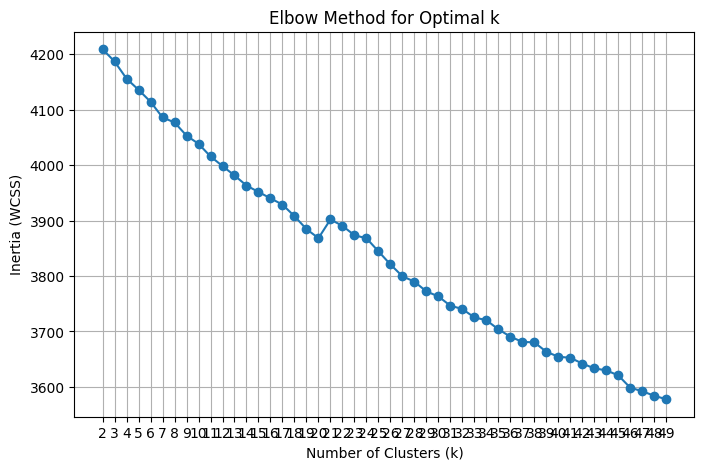

In [9]:
# --- Plot Elbow Chart ---
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

### Silhoouette Value

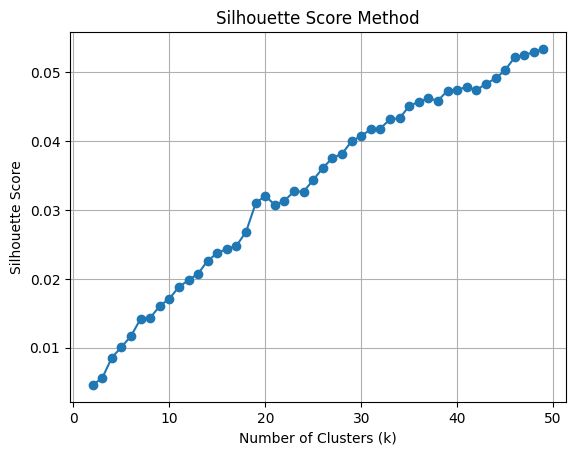

In [10]:
plt.plot(range(2, 50), silhouette_scores, marker='o')
plt.title("Silhouette Score Method")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

### Davies Bouldin

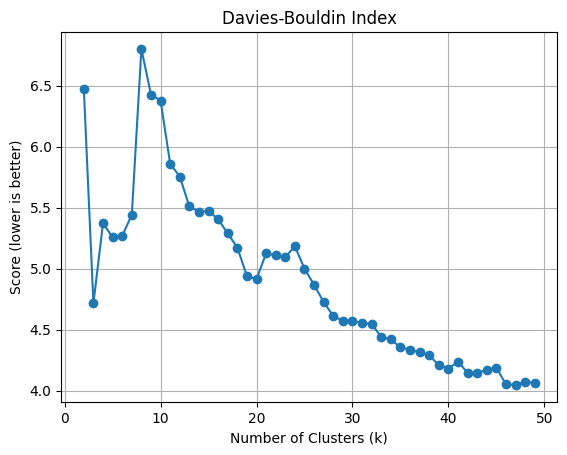

In [11]:
plt.plot(range(2, 50), db_scores, marker='o')
plt.title("Davies-Bouldin Index")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Score (lower is better)")
plt.grid(True)
plt.show()

### Calinski Harabasz

A higher value of CH indicates a better clustering, because it means that the data points are more spread out between clusters than they are within clusters.

In [ ]:
plt.plot(range(2, 50), ch_scores, marker='o')
plt.title("Calinski-Harabasz Index")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Score (higher is better)")
plt.grid(True)
plt.show()

## Cluster Distribution

In [70]:
k_values = range(2, 50)

rows, cols = 25, 2
fig, axes = plt.subplots(rows, cols, figsize=(50, 300))  # Adjust figsize as needed
axes = axes.flatten()

for k in k_values:
    col = f"cluster{k}"
    value_counts = products[col].value_counts().sort_index()

    ax = axes[k]
    value_counts.plot(kind='bar', ax=ax)
    # plt.bar(value_counts.index, value_counts.values)
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('Count')

## Qualitative Evaluation

In [71]:
products[["StockCode","Description","cluster9","cluster10"]].to_csv("clusteridf_label.csv")

In [80]:
clusteridf_result = pd.read_csv("clusteridf_label.csv")

In [82]:
clusteridf_result[clusteridf_result["cluster9"]==1].sample(50)

,Unnamed: 0,StockCode,Description,cluster9,cluster10
1929,1929,22719,GUMBALL MONOCHROME COAT RACK,1,1
56,56,16054,POPART RECT PENCIL SHARPENER ASST,1,1
2831,2831,79341,WILLOW BRANCH LIGHTS.,1,1
185,185,18098c,PORCELAIN BUTTERFLY OIL BURNER,1,1
2496,2496,47480,HANGING PHOTO CLIP ROPE LADDER,1,1
3779,3779,85196,EASTER BUNNIES ON A STICK,1,1
1350,1350,22104,MIRROR MOSAIC CANDLE PLATE,1,1
364,364,20864,DENIM PATCH PENCIL CASE BUTTERFLY,1,1
2944,2944,84249A,"GREETING CARD,SQUARE, DOUGHNUTS",1,1
586,586,21175,GIN + TONIC DIET METAL SIGN,1,1


# Unsupervised Embed LLM

## Transforming Sentence

In [72]:
model = SentenceTransformer('all-MiniLM-L6-v2')  # Replace with your local model if needed

In [73]:
embeddings = model.encode(products['clean_description'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/134 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Batches: 100%|██████████| 134/134 [00:01<00:00, 90.99it/s] 


## Clustering & Evaluation

### K-Means Clustering

In [74]:
inertia_embed = []
silhouette_scores_embed = []
db_scores_embed = []
ch_scores_embed = []

k_values_embed = range(2, 50)

for k in k_values_embed:
    cluster = f"cluster{k}"
    kmeans = KMeans(n_clusters=k, random_state=42)
    products[cluster] = kmeans.fit_predict(embeddings)
    
    inertia_embed.append(kmeans.inertia_)
    silhouette_scores_embed.append(silhouette_score(embeddings, kmeans.labels_))
    db_scores_embed.append(davies_bouldin_score(embeddings, kmeans.labels_))
    ch_scores_embed.append(calinski_harabasz_score(embeddings, kmeans.labels_))


### Inertia

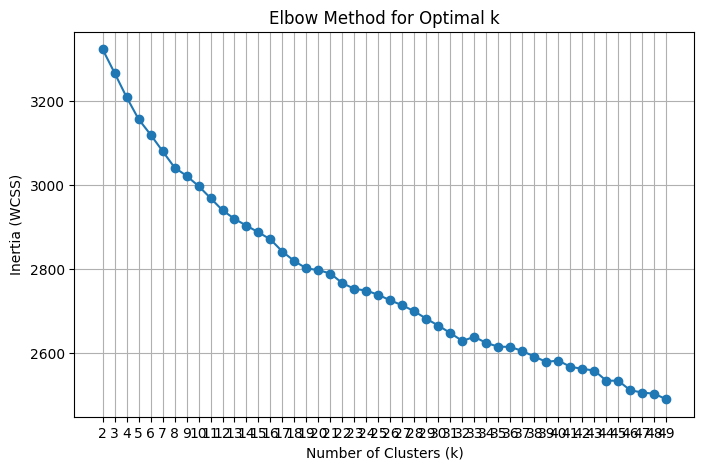

In [117]:
# --- Plot Elbow Chart ---
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_embed, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

### Sillhouette Value

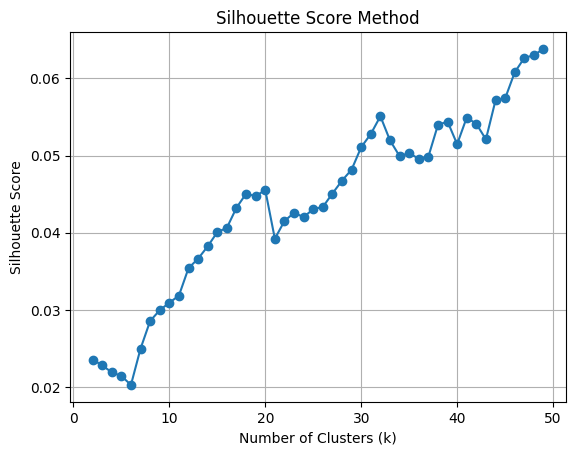

In [118]:
plt.plot(range(2, 50), silhouette_scores_embed, marker='o')
plt.title("Silhouette Score Method")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

### Davies Bouldin Value

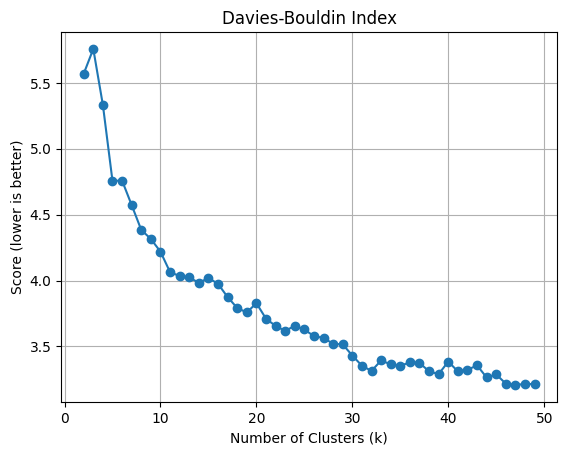

In [119]:
plt.plot(range(2, 50), db_scores_embed, marker='o')
plt.title("Davies-Bouldin Index")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Score (lower is better)")
plt.grid(True)
plt.show()

### Calinski Harabasz

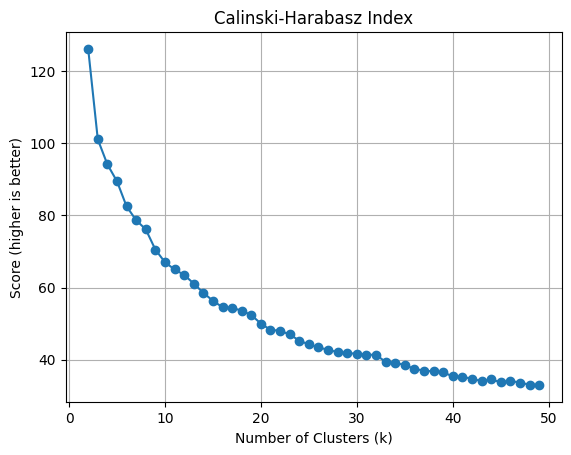

In [124]:
plt.plot(range(2, 50), ch_scores_embed, marker='o')
plt.title("Calinski-Harabasz Index")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Score (higher is better)")
plt.grid(True)
plt.show()

## Cluster Distribution

In [75]:
k_values = range(2, 50)

rows, cols = 25, 2
fig, axes = plt.subplots(rows, cols, figsize=(50, 300))  # Adjust figsize as needed
axes = axes.flatten()

for k in k_values:
    col = f"cluster{k}"
    value_counts = products[col].value_counts().sort_index()

    ax = axes[k]
    value_counts.plot(kind='bar', ax=ax)
    # plt.bar(value_counts.index, value_counts.values)
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('Count')

## Qualitative Evaluation

In [76]:
products[["StockCode","Description","cluster9","cluster10"]].to_csv("clusterllm_label.csv")

In [77]:
clusterllm_result = pd.read_csv("clusterllm_label.csv")

In [78]:
clusterllm_result[clusterllm_result["cluster9"]==2].sample(50)

,Unnamed: 0,StockCode,Description,cluster9,cluster10
2174,2174,22985,"WRAP, BILLBOARD FONTS DESIGN",2,2
2196,2196,35095A,BLUE VICTORIAN FABRIC OVAL BOX,2,9
2503,2503,47503H,ASS FLORAL PRINT SPIRIT LEVEL,2,5
367,367,20867,PINK ROSE FABRIC MIRROR,2,2
1335,1335,22089,PAPER BUNTING VINTAGE PAISLEY,2,9
868,868,21498,RED SPOTS WRAP,2,2
3060,3060,84536A,ENGLISH ROSE NOTEBOOK A7 SIZE,2,9
2693,2693,72754D,F FAIRY POTPOURRI CUSHIONS SUMMER,2,2
1918,1918,22708,WRAP DOLLY GIRL,2,2
964,964,21632,VINTAGE PINK DECORATIVE PARASOL,2,2


# Random Sampling Labelling

In [190]:
# Getting random sample data to be manually labelled
# sample = products[["StockCode","clean_description"]].sample(n=500, random_state=42)
# sample.to_csv("manual_labelled.csv",index=False)

# Supervised Learning

In [16]:
labelled_product = pd.read_csv("manual_labelled.csv")

In [9]:
labelled_product.isna().sum()

StockCode            0
clean_description    0
Category             0
dtype: int64

In [10]:
labelled_product.columns

Index(['StockCode', 'clean_description', 'Category'], dtype='object')

# Supervised TF/IDF

In [53]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.6)

In [54]:
vectorizer.fit_transform(labelled_product['clean_description'])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1974 stored elements and shape (497, 766)>

In [55]:
x_tfidf = vectorizer.fit_transform(labelled_product['clean_description'])
y_tfidf = labelled_product['Category']

In [30]:
x_tfidf_train, x_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(x_tfidf, y_tfidf, test_size=0.2, random_state=42)

### Logistic Regression

In [56]:
clfidf = LogisticRegression(max_iter=1000)

In [57]:
accuracy = cross_val_score(clfidf, x_tfidf_train, y_tfidf_train, cv=5, scoring='accuracy')
print("accuracy")
print(accuracy)

accuracy
[0.5        0.575      0.58227848 0.51898734 0.48101266]


In [58]:
# Train model
clfidf.fit(x_tfidf_train, y_tfidf_train)
# Evaluate
y_tfidf_pred = clfidf.predict(x_tfidf_test)

print(classification_report(y_tfidf_test, y_tfidf_pred))

                                   precision    recall  f1-score   support

      Candles, Scents & Body Care       0.88      0.50      0.64        14
            Cutlery & Kitchenware       0.54      0.87      0.67        15
                       Home Decor       0.64      0.47      0.54        15
              Household Appliance       0.30      0.75      0.43        12
Jewellery, Accessories & Wearable       0.71      0.56      0.62        18
                   Party Supplies       0.82      0.69      0.75        13
              Stationery & Office       1.00      0.20      0.33         5
                    Toys & Plushy       1.00      0.12      0.22         8

                         accuracy                           0.57       100
                        macro avg       0.74      0.52      0.53       100
                     weighted avg       0.70      0.57      0.57       100



### Gradient Boosting

In [59]:
gbclidf = GradientBoostingClassifier()

In [60]:
accuracy = cross_val_score(gbclidf, x_tfidf_train, y_tfidf_train, cv=5, scoring='accuracy')
print("accuracy")
print(accuracy)

accuracy
[0.5125     0.575      0.59493671 0.59493671 0.58227848]


In [61]:
# Train model
gbclidf.fit(x_tfidf_train, y_tfidf_train)

# Evaluate
y_tfidf_pred = gbclidf.predict(x_tfidf_test)
print(classification_report(y_tfidf_test, y_tfidf_pred))

                                   precision    recall  f1-score   support

      Candles, Scents & Body Care       0.77      0.71      0.74        14
            Cutlery & Kitchenware       0.85      0.73      0.79        15
                       Home Decor       0.62      0.33      0.43        15
              Household Appliance       0.30      0.83      0.44        12
Jewellery, Accessories & Wearable       0.82      0.78      0.80        18
                   Party Supplies       0.89      0.62      0.73        13
              Stationery & Office       0.40      0.40      0.40         5
                    Toys & Plushy       1.00      0.25      0.40         8

                         accuracy                           0.62       100
                        macro avg       0.71      0.58      0.59       100
                     weighted avg       0.73      0.62      0.63       100



# Supervised with Embed LLM

## Modelling

### Training

In [6]:
sentenceTransformer = SentenceTransformer('all-MiniLM-L6-v2')  # Replace with your local model if needed

In [11]:
x_transformed = sentenceTransformer.encode(labelled_product['clean_description'].tolist(), show_progress_bar=True)
y_transformed = labelled_product['Category']

Batches:   0%|          | 0/16 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Batches: 100%|██████████| 16/16 [00:00<00:00, 28.21it/s]


In [12]:
x_transformed_train, x_transformed_test, y_transformed_train, y_transformed_test = train_test_split(x_transformed, y_transformed, test_size=0.2, random_state=42)

### Logistic Regression

In [22]:
clflm = LogisticRegression(max_iter=1000)

In [23]:
accuracy = cross_val_score(clflm, x_transformed_train, y_transformed_train, cv=5, scoring='accuracy')
print("accuracy")
print(accuracy)

accuracy
[0.6375     0.6875     0.67088608 0.63291139 0.56962025]


In [24]:
# Train model
clflm.fit(x_transformed_train, y_transformed_train)

# Evaluate
y_pred = clflm.predict(x_transformed_test)
print(classification_report(y_transformed_test, y_pred))

                                   precision    recall  f1-score   support

      Candles, Scents & Body Care       0.79      0.79      0.79        14
            Cutlery & Kitchenware       0.62      0.67      0.65        15
                       Home Decor       0.69      0.73      0.71        15
              Household Appliance       0.43      0.83      0.57        12
Jewellery, Accessories & Wearable       0.81      0.72      0.76        18
                   Party Supplies       0.82      0.69      0.75        13
              Stationery & Office       1.00      0.20      0.33         5
                    Toys & Plushy       1.00      0.38      0.55         8

                         accuracy                           0.68       100
                        macro avg       0.77      0.63      0.64       100
                     weighted avg       0.74      0.68      0.68       100



### Gradient Boosting

In [25]:
gbcllm = GradientBoostingClassifier()

In [26]:
accuracy = cross_val_score(gbcllm, x_transformed_train, y_transformed_train, cv=5, scoring='accuracy')
print("accuracy")
print(accuracy)

accuracy
[0.55       0.5        0.53164557 0.56962025 0.49367089]


In [27]:
# Train model
gbcllm.fit(x_transformed_train, y_transformed_train)

# Evaluate
y_pred = gbcllm.predict(x_transformed_test)
print(classification_report(y_transformed_test, y_pred))

                                   precision    recall  f1-score   support

      Candles, Scents & Body Care       0.80      0.57      0.67        14
            Cutlery & Kitchenware       0.77      0.67      0.71        15
                       Home Decor       0.53      0.60      0.56        15
              Household Appliance       0.32      0.58      0.41        12
Jewellery, Accessories & Wearable       0.67      0.67      0.67        18
                   Party Supplies       0.75      0.46      0.57        13
              Stationery & Office       0.17      0.20      0.18         5
                    Toys & Plushy       0.17      0.12      0.14         8

                         accuracy                           0.54       100
                        macro avg       0.52      0.48      0.49       100
                     weighted avg       0.58      0.54      0.55       100



## Predict Unlabelled Categroy & Qualitative Evaluation

In [37]:
unlabelled_products = products[~products["StockCode"].isin(labelled_product["StockCode"])]

In [38]:
x_unlabelled_lm = sentenceTransformer.encode(unlabelled_products['clean_description'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/119 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Batches: 100%|██████████| 119/119 [00:01<00:00, 61.75it/s] 


In [62]:
x_unlabelled_tfidf = vectorizer.transform(unlabelled_products['clean_description'])

In [63]:
pred_clf_idf = clfidf.predict(x_unlabelled_tfidf)
pred_gbclidf = gbclidf.predict(x_unlabelled_tfidf)

In [45]:
pred_clflm = clflm.predict(x_unlabelled_lm)
pred_gbcllm = gbcllm.predict(x_unlabelled_lm)

In [48]:
pred_clflm

array(['Household Appliance', 'Stationery & Office', 'Party Supplies',
       ..., 'Party Supplies', 'Party Supplies', 'Stationery & Office'],
      dtype=object)

In [64]:
unlabelled_products['pred_clf_idf'] = pred_clf_idf
unlabelled_products['pred_gbclidf'] = pred_gbclidf

/var/folders/7w/tbvbjl3s2js6vp2mg4_3pldr0000gn/T/ipykernel_11088/2100078906.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabelled_products['pred_clf_idf'] = pred_clf_idf
/var/folders/7w/tbvbjl3s2js6vp2mg4_3pldr0000gn/T/ipykernel_11088/2100078906.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabelled_products['pred_gbclidf'] = pred_gbclidf


In [47]:
unlabelled_products['pred_clflm'] = pred_clflm
unlabelled_products['pred_gbcllm'] = pred_gbcllm

/var/folders/7w/tbvbjl3s2js6vp2mg4_3pldr0000gn/T/ipykernel_11088/344872419.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabelled_products['pred_clflm'] = pred_clflm
/var/folders/7w/tbvbjl3s2js6vp2mg4_3pldr0000gn/T/ipykernel_11088/344872419.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabelled_products['pred_gbcllm'] = pred_gbcllm


In [65]:
unlabelled_products.columns

Index(['Unnamed: 0', 'StockCode', 'Description', 'clean_description',
       'pred_clflm', 'pred_gbcllm', 'pred_clf_idf', 'pred_gbclidf'],
      dtype='object')

In [66]:
unlabelled_products.to_csv("supervised_labelled.csv", index=False)

In [67]:
unlabelled_products.head(20)

,Unnamed: 0,StockCode,Description,clean_description,pred_clflm,pred_gbcllm,pred_clf_idf,pred_gbclidf
0,0,10002,INFLATABLE POLITICAL GLOBE,inflatable political globe,Household Appliance,Party Supplies,Household Appliance,Household Appliance
1,1,10002R,ROBOT PENCIL SHARPNER,robot pencil sharpner,Stationery & Office,Toys & Plushy,Stationery & Office,Stationery & Office
2,2,10080,GROOVY CACTUS INFLATABLE,groovy cactus inflatable,Party Supplies,Household Appliance,Household Appliance,Household Appliance
3,3,10109,BENDY COLOUR PENCILS,bendy colour pencils,Stationery & Office,Stationery & Office,Stationery & Office,Stationery & Office
4,4,10120,DOGGY RUBBER,doggy rubber,Household Appliance,"Jewellery, Accessories & Wearable",Household Appliance,Household Appliance
5,5,10123C,HEARTS WRAPPING TAPE,hearts wrapping tape,Party Supplies,Stationery & Office,Stationery & Office,Stationery & Office
6,6,10123G,ARMY CAMO WRAPPING TAPE,army camo wrapping tape,Party Supplies,Party Supplies,Stationery & Office,Stationery & Office
7,7,10124A,SPOTS ON RED BOOKCOVER TAPE,spots on red bookcover tape,Stationery & Office,"Candles, Scents & Body Care",Stationery & Office,Stationery & Office
10,10,10133,COLOURING PENCILS BROWN TUBE,colouring pencils brown tube,Stationery & Office,Home Decor,Stationery & Office,Stationery & Office
11,11,10134,COLOURING PENCILS BROWN TUBE,colouring pencils brown tube,Stationery & Office,Home Decor,Stationery & Office,Stationery & Office


# Direct Prompting

## Prompting Execution

In [134]:
import ollama

In [135]:
categories = [
    "Candles, Scents & Body Care", "Jewellery, Accessories & Wearable", "Home Decor", 
    "Cutlery & Kitchenware", "Toys & Plushy", "Stationery & Office", "Household Appliance", "Party Supplies"
]

In [136]:
prompt_template = """
You are a senior inventory manager in a wholesale company. You are asked to put each product into category as defined by company.
The categories are:
1. Candles, Scents & Body Care: For all products relevant to perfume, scented candles, and body care products.
2. Jewellery, Accessories & Wearable: All product that can be worn like bag, clothes, jewellery hair accessories, etc.
3. Home Decor: efers to any item whose primary purpose is to enhance the aesthetic appeal, atmosphere, or thematic style of a living space — rather than to serve a strictly functional or structural purpose.
4. Cutlery & Kitchenware: Items used to cook and related to food
5. Toys & Plushy
6. Stationery & Office
7. Household Appliance
8. Party Supplies: Items used in party, gift card, ribbons, christmas and party decoration

List of product: "{product}"
Respond with only the category name.
"""

In [137]:
# Function to classify one row
def classify_product_ollama(product_name):
    prompt = prompt_template.format(
        product=product_name,
        categories=", ".join(categories)
    )
    response = ollama.chat(model="mistral", messages=[{"role": "user", "content": prompt}])
    return response["message"]["content"].strip()


In [141]:
# Apply prompt to all data at once
# products['category'] = products['clean_description'].apply(classify_product_ollama)
# products_labeled.to_csv("direct_prompt_result.csv", index=False)

# Apply prompt in batch
batch_size = 500
for i in range(0, len(products), batch_size):
    batch = products.iloc[i:i+batch_size].copy()
    batch['category'] = batch['clean_description'].apply(classify_product_ollama)
    results.append(batch)

# Combine all batches back into a single DataFrame
products_labeled = pd.concat(results, ignore_index=True)
products_labeled.to_csv("direct_prompt_result", index=False)
del products_labeled

## Evaluation

In [5]:
direct_prompt_result = pd.read_csv("direct_prompt_result.csv")

In [6]:
direct_prompt_result["predicted_category"] = direct_prompt_result["category"]

In [17]:
evaluate_result = pd.merge(direct_prompt_result[["StockCode","Description","predicted_category"]], labelled_product, on='StockCode')

In [10]:
evaluate_result

,StockCode,Description,predicted_category,clean_description,Category
0,10124G,ARMY CAMO BOOKCOVER TAPE,Home Decor (as it enhances the aesthetic appea...,army camo bookcover tape,Stationery & Office
1,16168M,FUNKY MONKEY GIFT BAG MEDIUM,Home Decor,funky monkey gift bag medium,Party Supplies
2,16202A,PASTEL PINK PHOTO ALBUM,Home Decor,pastel pink photo album,Stationery & Office
3,16225,RATTLE SNAKE EGGS,Toys & Plushy,rattle snake eggs,Toys & Plushy
4,16256C,HEARTS PENCIL/RUBBER+5 MINI PENCILS,Stationery & Office,hearts pencilrubber mini pencils,Stationery & Office
...,...,...,...,...,...
243,90185A,AMBER DIAMANTE EXPANDABLE RING,"Jewellery, Accessories & Wearable",amber diamante expandable ring,"Jewellery, Accessories & Wearable"
244,90187B,GREEN DROP EARRINGS W BEAD CLUSTER,"Jewellery, Accessories & Wearable",green drop earrings w bead cluster,"Jewellery, Accessories & Wearable"
245,90196A,PURPLE GEMSTONE NECKLACE 45CM,"Jewellery, Accessories & Wearable",purple gemstone necklace cm,"Jewellery, Accessories & Wearable"
246,90199C,5 STRAND GLASS NECKLACE CRYSTAL,"Jewellery, Accessories & Wearable",strand glass necklace crystal,"Jewellery, Accessories & Wearable"


In [18]:
evaluate_result.to_csv("evaluate_result_prompt.csv", index=False)

In [19]:
evaluate_result[evaluate_result["Category"] == evaluate_result["predicted_category"]].count()

StockCode             196
Description           196
predicted_category    196
clean_description     196
Category              196
dtype: int64

In [20]:
evaluate_result.count()

StockCode             497
Description           497
predicted_category    497
clean_description     497
Category              497
dtype: int64

In [21]:
(evaluate_result[evaluate_result["Category"] == evaluate_result["predicted_category"]].count())/evaluate_result.count()

StockCode             0.394366
Description           0.394366
predicted_category    0.394366
clean_description     0.394366
Category              0.394366
dtype: float64